In [1]:
import os, sys
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2022-08-29 11:14:31.644670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 11:14:31.645004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 11:14:31.684097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 11:14:31.684444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 11:14:31.684709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/l/projects/Morpheus/Tutorial/BayesFlow/bayesflow/trainers.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import time
import glob
import subprocess

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
RNG = np.random.default_rng(2022)

In [7]:
def model_prior():
    b_cf = RNG.uniform(low=0.01,high=1)
    b_c2c = RNG.uniform(low=0.01,high=1)
    c_V = RNG.uniform(low=0.01,high=1)
    p_i = RNG.uniform(low=0.01,high=1)
    I0 = 1
    return np.array([b_cf, b_c2c, c_V, p_i])

In [8]:
models = "trained_models"
param_nr = len(model_prior())
summary_parm = 1
inn_layer = 8
checkpoint_path=os.path.abspath(os.path.join(os.getcwd(), models,"summary_more_power_online_" "pr-" + str(param_nr) + "_sr-" +  str(summary_parm) + "_inn_layer-" + str(inn_layer) + "_" + datetime.now(tz=None).strftime("%Y%m%d_%H:%M:%S")))

In [17]:
checkpoint_path

'/home/l/projects/Morpheus/Tutorial/infectionSpread/trained_models/summary_more_power_online_pr-4_sr-1_inn_layer-8_20220829_11:14:32'

In [9]:
prior = Prior(prior_fun=model_prior, param_names=[r'b_cf',r'b_c2c',r'c_V',r'p_i'])

In [10]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [11]:
def run_morpheus(params, T0=10, t=100):
    b_cf, b_c2c, c_V, p_i = params
    
    #I0 = np.ceil(I0)
    #T = np.clip(T0-I0, 0, T0)
    
    #!MODEL_DIR='model'
    #!MODEL="$(ls  ${DIR}/${MODEL_DIR}/*.xml)"
    model_dir='model'
    model=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))[0]
    print(model)

    OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
    print(OUT)
    !mkdir "$OUT"
    !morpheus -f "$model" -o "$OUT" -b_cf="$b_cf" -b_c2c="$b_c2c" -c_V="$c_V" -p_i="$p_i"
    
    final_plot = os.path.join(OUT,'plot-1_' + str(t).zfill(5) + '.png')
    while not os.path.exists(final_plot):
        time.sleep(1)
    
    population_file = os.path.join(OUT,'logger_3.csv')
    pop = np.genfromtxt(population_file, delimiter='\t', names=True)
    pop = np.array([list(i) for i in zip(*pop)])
    return np.expand_dims(pop[2,:], axis=1)

In [12]:
config = {
    'T' : 10,
    't' : 100
}

In [13]:
simulator = Simulator(simulator_fun=partial(run_morpheus, T0=config['T'], t=config['t']))

In [14]:
model = GenerativeModel(prior, simulator, name='morpheus')

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.7723615326818378_bc2c-0.3546143421326271_cV-0.19710729416892536_pi-0.24438002474303128
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.7723615326818378_bc2c-0.3546143421326271_cV-0.19710729416892536_pi-0.24438002474303128“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.7723615326818378_bc2c-0.3546143421326271_cV-0.19710729416892536_pi-0.24438002474303128
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661764476
Random seed of thread 3 = 236431
Random seed of thread 12 = 2090181
Random seed of thread 8 = 2

INFO:root:Performing 2 pilot runs with the morpheus model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


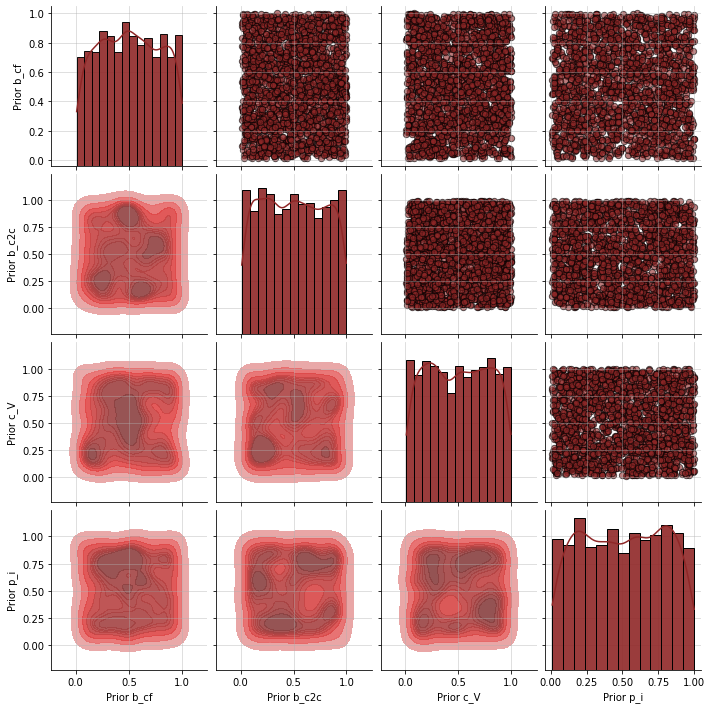

In [15]:
f = prior.plot_prior2d()

In [16]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, n_summary):
        super(ConvLSTM, self).__init__()

        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=3, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu')
        ])
        
    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""
        out = self.conv(x)
        out = self.lstm(out)
        out = self.dense(out)

        return out

In [18]:
summary_net = ConvLSTM(n_summary=summary_parm)

: 

: 

In [ ]:
inference_net = InvertibleNetwork({
    'n_params': param_nr, 
    'n_coupling_layers': inn_layer, 
})

In [ ]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='amortizer')

In [ ]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {}
    
    # Convert data to logscale 
    logdata = forward_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [ ]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input,
                  checkpoint_path=checkpoint_path)

INFO:root:Performing a consistency check with provided components...


/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.5466465186819057
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.5466465186819057“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.5466465186819057
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661265877
Random seed of thread 7 = 7739283
Random seed of thread 2 = 5004943
Random seed of thread 4 = 1225748
Random seed of thread 12 = 9879728
Random seed of thread 14 = 6408576
Random seed of thread 6 = 9610915
Random seed of thread 9 = 1724731
Random seed of thread 1 = 1681149
Random seed of t

2022-08-23 16:44:39.382128: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-23 16:44:39.845581: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
INFO:root:Done.


In [ ]:
amortizer.summary()

Model: "amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 53796     
 bleNetwork)                                                     
                                                                 
 conv_lstm_1 (ConvLSTM)      multiple                  130       
                                                                 
Total params: 53,926
Trainable params: 53,914
Non-trainable params: 12
_________________________________________________________________


In [ ]:
%%time
_ = model(32)

In [ ]:
%%time
h = trainer.train_online(epochs=2, iterations_per_epoch=2, batch_size=10)

Training epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.15697702274048497
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.15697702274048497“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.15697702274048497
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661265910
Random seed of thread 8 = 1268039
Random seed of thread 6 = 1307310
Random seed of thread 4 = 5777072
Random seed of thread 14 = 6365820
Random seed of thread 12 = 6460732
Random seed of thread 9 = 4257218
Random seed of thread 1 = 2756484
Random seed of thread 15 = 5583521
Random seed 

Training epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.614504749796766
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.614504749796766“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output_c2c/bc2c-0.614504749796766
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_few_param.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661265926
Random seed of thread 5 = 1343672
Random seed of thread 10 = 2532788
Random seed of thread 1 = 6494522
Random seed of thread 7 = 3673784
Random seed of thread 13 = 2291099
Random seed of thread 11 = 5057367
Random seed of thread 3 = 878882
Random seed of thread 8 = 1850949
Random seed of thre

In [ ]:
h

,Default.Loss
0,1.895443
1,1.663057
2,0.736075
3,1.358885


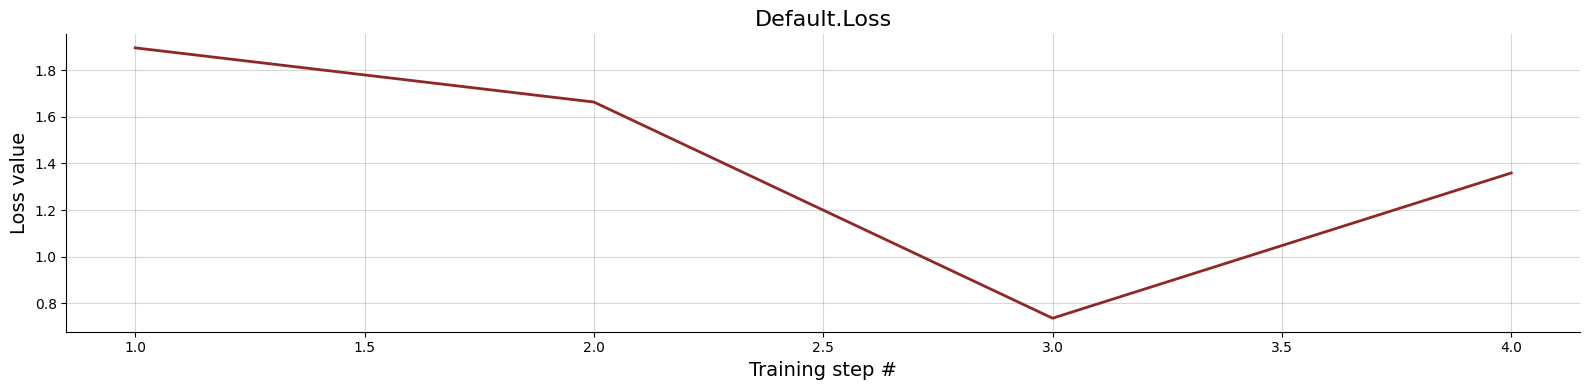

In [ ]:
f = diag.plot_losses(h)

In [ ]:
f = trainer.diagnose_latent2d()

AttributeError: Exception encountered when calling layer "amortizer" (type AmortizedPosterior).

'NoneType' object has no attribute 'get'

Call arguments received by layer "amortizer" (type AmortizedPosterior):
  • input_dict=None
  • return_summary=False
  • kwargs={'training': 'None'}

In [ ]:
f = trainer.diagnose_sbc_histograms()

In [ ]:
b_cf = 1
b_c2c = 1
c_V = 1
p_i = 1
I0 = 1
params = np.array([b_cf, b_c2c, c_V, p_i, I0])

In [ ]:
pop = run_morpheus(params, 10, 100)

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
Initializing from file /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659355370
Random seed of thread 7 = 9507902
Random seed of thread 6 = 6909739
Random seed of thread 3 = 267710
Random seed of thread 1 = 1639870
Random seed of thread 2 = 8365403
Random seed of thread 4 = 751819
Random seed of thread 5 = 2297337
Registering Symbol space of linktype LocationLink in Scope root
Reg

In [ ]:
pop = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop[:,2]

In [ ]:
OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
population_file = os.path.join(OUT,'logger_3.csv')
pop = np.genfromtxt(population_file, delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop = np.expand_dims(pop[2,:], axis=1)

In [ ]:
popul = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)

In [ ]:
pop

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 7.],
       [ 9.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
      

In [ ]:
popul[2,:]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,
        4.,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [ ]:
model_dir='model'
models=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))
model=models[0]
!echo "$model"
#!morpheus -f '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml' -o '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1'

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
